# Churn model for Insurance Company

The first attempt will be to try to predict the drivers of churn based on a classification method. The data contains flags relevant to customers demographics, claim and service behaviour and policy characteristics.

In [1]:
import pandas as pd

###### ** Changes from dataset version 2 to version 6:**

The data source had to be changed in order to address few issues/opportunities:
- the field AvgTurnaround had too many null values. Considering that only customers who claim will have this information, I couldn't find a way to keep the information in. So, for this reason it has been excluded from the datased
- the field CXMonthsFromRenewal also contained too many null values. The objective of the field is to provide the number of months that the policy is in the policy period, which expires every 12 months. There is a hypothesis that indicates that the customers are more likely to cancel when their policy is about to expiry
- the data size - reduce to only use policies with 0 to 5 years of tenure
- added data about latest claim and further demographics

This version of the notebook has been created in order to address the changes to be made in the categorical variables


In [60]:
policies = pd.read_table('ChurnModelDatasetV6.txt',index_col='no_')

In [61]:
### policies.shape
#policies.values            # underlying numpy array
policies.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267377 entries, 459905 to 393303
Data columns (total 37 columns):
Cancelled                      267377 non-null int64
PlanType                       267377 non-null object
ClaimedInThePast               267377 non-null int64
BenefitToClaimRatio            267377 non-null float64
irsd_decile                    265673 non-null float64
premium payment period code    267377 non-null object
payment method code            267377 non-null object
InsuredGender                  267377 non-null object
premium                        267377 non-null float64
PremiumDecile                  267377 non-null int64
breed risk group               267377 non-null int64
CXMonthsFromRenewal            267377 non-null int64
TenureInMonths                 267377 non-null int64
PetAgeInMonths                 267377 non-null int64
ClientAgeInMonths              267377 non-null int64
SalesChannel                   267377 non-null object
pet agegroup when join   

**Interpreting the quantiles**
- Ntile5LastClaimAmount - 5 tile, 1 = lowest value
- Ntile5LastPaidAmount - 5 tile, 1 = lowest value
- PremiumDecile - 10 tile, 1 = lowest value

In [62]:
## remove columns that won't be used
policies.columns = [c.replace(' ', '_') for c in policies.columns]
policies.drop('premium', axis=1, inplace=True)
policies.drop('ClientAgeInMonths', axis=1, inplace=True)
policies.drop('PetAgeInMonths', axis=1, inplace=True)
policies.drop('petAgeInYears', axis=1, inplace=True)
policies.drop('ClientAgeInYears', axis=1, inplace=True)
policies.drop('Insured_Gender', axis=1, inplace=True)
policies.drop('Brand',axis=1,inplace=True)
policies.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267377 entries, 459905 to 393303
Data columns (total 30 columns):
Cancelled                      267377 non-null int64
PlanType                       267377 non-null object
ClaimedInThePast               267377 non-null int64
BenefitToClaimRatio            267377 non-null float64
irsd_decile                    265673 non-null float64
premium_payment_period_code    267377 non-null object
payment_method_code            267377 non-null object
InsuredGender                  267377 non-null object
PremiumDecile                  267377 non-null int64
breed_risk_group               267377 non-null int64
CXMonthsFromRenewal            267377 non-null int64
TenureInMonths                 267377 non-null int64
SalesChannel                   267377 non-null object
pet_agegroup_when_join         267377 non-null object
client_agegroup_when_join      267377 non-null object
NumberCalls                    267377 non-null int64
ClaimReviews             

In [63]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') # This styles the graphs in a nicer format

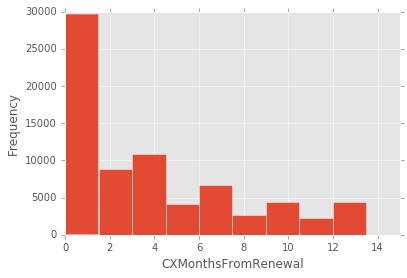

In [64]:
policies[policies.Cancelled == 1].CXMonthsFromRenewal.plot(kind='hist', xlim=(0,15))
#policies.CXMonthsFromRenewal.hist(by=policies.Cancelled, sharex=True, sharey=True)
plt.xlabel('CXMonthsFromRenewal')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 267377 entries, 459905 to 393303
Data columns (total 30 columns):
Cancelled                      267377 non-null int64
PlanType                       267377 non-null object
ClaimedInThePast               267377 non-null int64
BenefitToClaimRatio            267377 non-null float64
irsd_decile                    265673 non-null float64
premium_payment_period_code    267377 non-null object
payment_method_code            267377 non-null object
InsuredGender                  267377 non-null object
PremiumDecile                  267377 non-null int64
breed_risk_group               267377 non-null int64
CXMonthsFromRenewal            267377 non-null int64
TenureInMonths                 267377 non-null int64
SalesChannel                   267377 non-null object
pet_agegroup_when_join         267377 non-null object
client_agegroup_when_join      267377 non-null object
NumberCalls                    267377 non-null int64
ClaimReviews             

01-02     65676
02-03     49316
00-01     49113
03-04     24473
04-05     18301
05-06     15230
06-07     12523
07-08      9971
08-09      8438
09-10      5603
11-100     5359
10-11      3374
Name: PetAgeGroup, dtype: int64

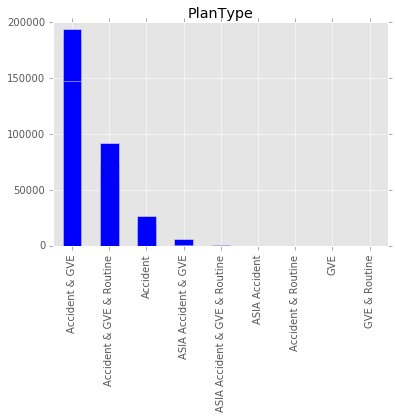

In [65]:
#transforming the string values into numeric values

policies.LastClaimStatus.value_counts().plot(kind='bar', title='Last Claim Status')
policies.InsuredGender.value_counts().plot(kind='bar', title='Gender')
policies.PlanType.value_counts().plot(kind='bar',title='PlanType')
policies.PlanType.value_counts()
policies.info()
policies.premium_payment_period_code.value_counts()
policies.payment_method_code.value_counts()
policies.species_code.value_counts()
policies.State.value_counts()
policies.ClientAgeInGroup.value_counts()
policies.PetAgeGroup.value_counts()

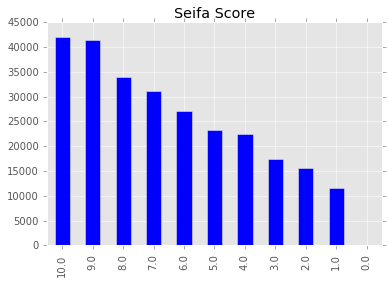

In [66]:
# check for missing values
policies.dropna(inplace=True)

policies.isnull().sum()

policies.irsd_decile.value_counts().plot(kind='bar', title='Seifa Score')

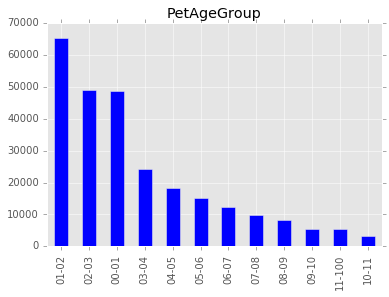

In [105]:
policies.PetAgeGroup.value_counts().plot(kind='bar', title='PetAgeGroup')


## Treating Categorical Data

In [70]:
# the categorical variables had been initially transformed to several numbers. In this version I will try to turn them into boolean values

policies.InsuredGender.value_counts()
policies['InsGenderFemale'] =  policies.InsuredGender.map({'Male':0, 'Female':1})

policies.InsGenderFemale.value_counts()

1    193226
0     72423
Name: InsGenderFemale, dtype: int64

In [71]:
#policies.species_code.replace(['CANINE','FELINE'],[1,2], inplace=True)
policies.species_code.value_counts()
policies['SpeciesDog'] =  policies.species_code.map({'FELINE':0, 'CANINE':1})
policies.SpeciesDog.value_counts()

1    224477
0     41172
Name: SpeciesDog, dtype: int64

In [72]:
#policies.LastClaimStatus.replace(['No Claims', 'Accepted with Pay', 'Denied', 'Accepted no Pay', 'Other'],  [1, 2, 3, 4, 0], inplace=True)
policies.LastClaimStatus.value_counts()
policies['LastClaimAcceptedNoPay'] =  policies.LastClaimStatus.map({'No Claims':0,'Accepted with Pay':0,'Denied':0,'Accepted no Pay':1,'Other':0}) 
policies['LastClaimAcceptedPay'] =  policies.LastClaimStatus.map({'No Claims':0,'Accepted with Pay':1,'Denied':0,'Accepted no Pay':0,'Other':0}) 
policies['LastClaimDenied'] =  policies.LastClaimStatus.map({'No Claims':0,'Accepted with Pay':0,'Denied':1,'Accepted no Pay':0,'Other':0}) 

policies.LastClaimDenied.value_counts()

0    248029
1     17620
Name: LastClaimDenied, dtype: int64

In [73]:
#policies.premium_payment_period_code.replace(['FORTNIGHTL','MONTHLY','ANNUALLY'],[1,2,3], inplace=True)
policies.premium_payment_period_code.value_counts()
policies['PayFreqFortnight'] =  policies.premium_payment_period_code.map({'FORTNIGHTL':1,'MONTHLY':0,'ANNUALLY':0}) 
policies['PayFreqMonth'] =  policies.premium_payment_period_code.map({'FORTNIGHTL':0,'MONTHLY':1,'ANNUALLY':0}) 
policies['PayFreqAnnual'] =  policies.premium_payment_period_code.map({'FORTNIGHTL':0,'MONTHLY':0,'ANNUALLY':1}) 

policies.PayFreqAnnual.value_counts()

0    237658
1     27991
Name: PayFreqAnnual, dtype: int64

In [79]:
#policies.payment_method_code.replace(['CC','BANK','CHEQUE'],[1,2,3], inplace=True)
policies.payment_method_code.value_counts()
policies['PayMethCC'] =  policies.payment_method_code.map({'CC':1,'BANK':0,'CHEQUE':0}) 

#due to low volumne of cheque, it has been put together with Bank
policies['PayMethBank'] =  policies.payment_method_code.map({'CC':0,'BANK':1,'CHEQUE':1}) 

policies.PayMethCC.value_counts()

0    146332
1    119317
Name: PayMethBank, dtype: int64

In [82]:
#policies.State.replace(['NSW','VIC','QLD','WA','SA','ACT','TAS','NT'],[1,2,3,4,5,6,7,8], inplace=True)
policies.State.value_counts()
policies['StateNSW'] =  policies.State.map({'NSW':1,'VIC':0,'QLD':0,'WA':0,'SA':0,'ACT':0,'TAS':0,'NT':0}) 
policies['StateVIC'] =  policies.State.map({'NSW':0,'VIC':1,'QLD':0,'WA':0,'SA':0,'ACT':0,'TAS':0,'NT':0}) 
policies['StateQLD'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':1,'WA':0,'SA':0,'ACT':0,'TAS':0,'NT':0}) 
policies['StateWA'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':1,'SA':0,'ACT':0,'TAS':0,'NT':0}) 
policies['StateSA'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':0,'SA':1,'ACT':0,'TAS':0,'NT':0}) 
policies['StateACT'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':0,'SA':0,'ACT':1,'TAS':0,'NT':0}) 
policies['StateTAS'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':0,'SA':0,'ACT':0,'TAS':1,'NT':0}) 
policies['StateNT'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':0,'SA':0,'ACT':0,'TAS':0,'NT':1}) 

policies.StateNSW.value_counts()

0    198566
1     67083
Name: StateNSW, dtype: int64

In [85]:
#policies.PlanType.replace(['Accident & GVE', 'Accident & GVE & Routine','Accident','ASIA Accident & GVE',
#                         'ASIA Accident & GVE & Routine','ASIA Accident','Accident & Routine','GVE & Routine','GVE'], 
#                          [1, 2,3,1,2,3,4,4,4], inplace=True)

policies.PlanType.value_counts()
policies['PlanAccGVERout'] =  policies.PlanType.map({'Accident & GVE':0,'Accident & GVE & Routine':1,'Accident':0,
                                                     'ASIA Accident & GVE':0,'ASIA Accident & GVE & Routine':1,
                                                     'ASIA Accident':0,'Accident & Routine':0,'GVE':0,'GVE & Routine':0}) 

policies['PlanAccOnly'] =  policies.PlanType.map({'Accident & GVE':0,'Accident & GVE & Routine':0,'Accident':1,
                                                     'ASIA Accident & GVE':0,'ASIA Accident & GVE & Routine':0,
                                                     'ASIA Accident':1,'Accident & Routine':0,'GVE':0,'GVE & Routine':0}) 

policies['PlanAccGVE'] =  policies.PlanType.map({'Accident & GVE':1,'Accident & GVE & Routine':0,'Accident':0,
                                                     'ASIA Accident & GVE':1,'ASIA Accident & GVE & Routine':0,
                                                     'ASIA Accident':0,'Accident & Routine':0,'GVE':0,'GVE & Routine':0}) 

policies['PlanOther'] =  policies.PlanType.map({'Accident & GVE':0,'Accident & GVE & Routine':0,'Accident':0,
                                                     'ASIA Accident & GVE':0,'ASIA Accident & GVE & Routine':0,
                                                     'ASIA Accident':0,'Accident & Routine':1,'GVE':1,'GVE & Routine':1}) 


policies.PlanOther.value_counts()

0    265611
1        38
Name: PlanOther, dtype: int64

In [89]:
#policies.ClientAgeInGroup.replace(['00-19','20-29','30-39','40-49','50-59','60-100'],[1,2,3,4,5,6],inplace=True)

policies.ClientAgeInGroup.value_counts()
policies['ClientAge00to19'] =  policies.ClientAgeInGroup.map({'00-19':1,'20-29':0,'30-39':0,'40-49':0,'50-59':0,'60-100':0}) 
policies['ClientAge20to29'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':1,'30-39':0,'40-49':0,'50-59':0,'60-100':0}) 
policies['ClientAge30to39'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':0,'30-39':1,'40-49':0,'50-59':0,'60-100':0}) 
policies['ClientAge40to49'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':0,'30-39':0,'40-49':1,'50-59':0,'60-100':0}) 
policies['ClientAge50to59'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':0,'30-39':0,'40-49':0,'50-59':1,'60-100':0}) 
policies['ClientAge60Plus'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':0,'30-39':0,'40-49':0,'50-59':0,'60-100':1}) 


policies.ClientAge00to19.value_counts()


0    263200
1      2449
Name: ClientAge00to19, dtype: int64

In [108]:
#policies.PetAgeGroup.replace(['00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-100'],[1,2,3,4,5,6,7,8,9,10,11,12],inplace=True)     
policies.PetAgeGroup.value_counts()

policies['PetAge00to01'] =  policies.PetAgeGroup.map({'00-01':1,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,'06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge01to02'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':1,'02-03':0,'03-04':0,'04-05':0,'05-06':0,'06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge02to03'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':1,'03-04':0,'04-05':0,'05-06':0,'06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge03to04'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':1,'04-05':0,'05-06':0,'06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge04to05'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':1,'05-06':0,'06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge05to06'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':1,'06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge06to07'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,'06-07':1,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge07to08'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,'06-07':0,'07-08':1,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge08to09'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,'06-07':0,'07-08':0,'08-09':1,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge09to10'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,'06-07':0,'07-08':0,'08-09':0,'09-10':1,'10-11':0,'11-100':0}) 
policies['PetAge10Plus'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,'06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':1,'11-100':1}) 

policies.PetAge00to01.value_counts() ##48830

0    216819
1     48830
Name: PetAge00to01, dtype: int64

In [109]:
policies.drop('InsuredGender', axis=1, inplace=True)
policies.drop('species_code', axis=1, inplace=True)
policies.drop('LastClaimStatus', axis=1, inplace=True)
policies.drop('premium_payment_period_code', axis=1, inplace=True)
policies.drop('payment_method_code', axis=1, inplace=True)
policies.drop('PayMethCheque', axis=1, inplace=True)
policies.drop('State', axis=1, inplace=True)
policies.drop('PlanType', axis=1, inplace=True)
policies.drop('ClientAgeInGroup', axis=1, inplace=True)
policies.drop('PetAgeGroup', axis=1, inplace=True)

policies.describe()



,Cancelled,ClaimedInThePast,BenefitToClaimRatio,irsd_decile,PremiumDecile,breed_risk_group,CXMonthsFromRenewal,TenureInMonths,NumberCalls,ClaimReviews,...,PetAge01to02,PetAge02to03,PetAge03to04,PetAge04to05,PetAge05to06,PetAge06to07,PetAge07to08,PetAge08to09,PetAge09to10,PetAge10Plus
count,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,...,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000
mean,0.276041,0.305877,0.115154,6.564877,5.501835,0.681968,9.716178,10.692143,1.801272,0.010111,...,0.245587,0.184322,0.091576,0.068474,0.056970,0.046866,0.037286,0.031527,0.020945,0.032633
std,0.447038,0.460779,0.235857,2.699829,2.871830,1.504581,4.181044,8.150653,2.992738,0.100044,...,0.430436,0.387747,0.288427,0.252558,0.231786,0.211353,0.189462,0.174736,0.143200,0.177675
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.000000,3.000000,0.000000,10.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,7.000000,6.000000,0.000000,12.000000,10.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,9.000000,8.000000,0.000000,12.000000,17.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.100062,10.000000,10.000000,6.000000,15.000000,37.000000,138.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
policies.BenefitToClaimRatio.plot(kind='density', xlim=(0,1))
plt.xlabel('Benefit To Claim Ratio')

In [ ]:
policies.info()

In [ ]:
policies.Ntile5LastPaidAmount.hist(by=policies.Cancelled, sharex=True, sharey=True)

In [ ]:
policies.OtherPets.hist(by=policies.Cancelled, sharex=True, sharey=True)

In [ ]:
colors = np.where(policies.species_code==1, 'r', 'b') #canine red
policies.plot(kind='scatter', x='TenureInMonths', y='MOnthsSinceLastClaim', c=colors)

## Trying Linear Regression

In [ ]:
# compute null accuracy manually for comparison reasosn
print policies['Cancelled'].mean()
print 1 - policies['Cancelled'].mean()

In [ ]:
#pd.scatter_matrix(policies, figsize=(30,30))

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
policies.describe()

In [ ]:
policies.corr()

In [ ]:
lm = smf.ols(formula='Cancelled ~ CXMonthsFromRenewal + OtherPets + MOnthsSinceLastClaim + LastClaimStatus + PetAgeGroup', data=policies).fit()

# print the coefficients
lm.params

In [ ]:
lm.summary()

In [ ]:
policies.Cancelled.value_counts()
# cancelled policies make up to 72.4% of the dataset so the model isn't really predicting any better

In [ ]:
! pip install seaborn

In [ ]:
plt.scatter(policies.TenureInMonths, policies.Cancelled)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)

feature_cols = ['MOnthsSinceLastClaim']
X = policies[feature_cols]
y = policies.Cancelled
logreg.fit(X, y)
policies_pred_class = logreg.predict(X)

In [ ]:
# plot the class predictions
plt.scatter(policies.MOnthsSinceLastClaim, policies.Cancelled)
plt.plot(policies.MOnthsSinceLastClaim, policies_pred_class, color='red')

In [ ]:
policies_pred_prob = logreg.predict_proba(X)[:, 1]
policies_pred_prob

In [ ]:
# plot the predicted probabilities
plt.scatter(policies.MOnthsSinceLastClaim, policies.Cancelled)
plt.plot(policies.MOnthsSinceLastClaim, policies_pred_prob, color='red')

In [ ]:
#print logreg.predict_proba(11)

In [ ]:
policies.describe()

In [ ]:
feature_cols = ['species_code','irsd_decile',
                'State','OtherPets',
                'MOnthsSinceLastClaim','LastClaimStatus','Ntile5LastClaimAmount','Ntile5LastPaidAmount',
                'PortalUser','OtherMembershipNumber','ClientAgeInGroup','PetAgeGroup','PremiumDecile','InsuredGender',
                'payment_method_code','premium_payment_period_code','ClaimedInThePast','PlanType']
X = policies[feature_cols]
y = policies.Cancelled

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression()
#logreg.fit(X_train, y_train)
#zip(feature_cols, logreg.coef_[0])

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
Cancelled_pred_class = logreg.predict_proba(X_train)[:, 1]
Cancelled_pred_class

In [ ]:
import numpy as np
print 'no regularization =', np.sqrt(metrics.mean_squared_error(y_train, Cancelled_pred_class))

In [ ]:
from sklearn import metrics
prds = logreg.predict(X)
print metrics.confusion_matrix(y, prds)

- Accuracy = (177710+28894)/265649 == 0.78
- Specificity = 177710 / (177710 + 14609) == 0.92

In [ ]:
print metrics.accuracy_score(y, prds)

## Trying Regularization

In [ ]:
from sklearn.linear_model import LassoCV
alpha_range = 10.**np.arange(-2, 3)
laspolicies = LassoCV(normalize=True, alphas=alpha_range)
laspolicies.fit(X_train, y_train)
laspolicies.alpha_
laspolicies.coef_
preds2 = laspolicies.predict(X_test)
print 'Lasso CV reg =', np.sqrt(metrics.mean_squared_error(y_test, preds2))

## Trying Decision Trees

In [ ]:
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline

policies.Cancelled.mean() 

In [ ]:
cancelled = policies['Cancelled']

X_train, X_test, y_train, y_test = train_test_split(policies,cancelled, random_state=1)

# Create a decision tree classifier instance (start out with a small tree for interpretability)
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# Fit the decision tree classifier
ctree.fit(X_train, y_train)



In [ ]:
ctree.classes_

In [ ]:
# Which features are the most important?
ctree.feature_importances_


In [ ]:
# Clean up the output
pd.DataFrame(zip(features, ctree.feature_importances_)).sort_index(by=1, ascending=False)

In [ ]:
# Make predictions on the test set
preds = ctree.predict(X_test)

# Calculate accuracy
metrics.accuracy_score(y_test, preds)

In [ ]:
# Confusion matrix
pd.crosstab(y_test, preds, rownames=['actual'], colnames=['predicted'])

# Make predictions on the test set using predict_proba
probs = ctree.predict_proba(X_test)[:,1]

# Calculate the AUC metric
metrics.roc_auc_score(y_test, probs)

# Decision Trees have notorouisly high variance, so what can we do
# to better estimate the out of sample error of a high variance model?

In [ ]:
import StringIO
from IPython.display import Image
import pydot
# make sure pydot and graphviz are installed 
# if problems see here:
# http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will/17902926#17902926

dot_data = StringIO.StringIO()  
tree.export_graphviz(
    ctree, 
    out_file=dot_data,
    feature_names=features,  
    class_names=["cancelled","active"],  
    filled=True, 
    rounded=True,  
    special_characters=True
)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
policies.describe()


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# compare AUC using cross-validation
#from sklearn.cross_validation import cross_val_score
#cross_val_score(logreg, policies, Cancelled, cv=10, scoring='roc_auc').mean()
#cross_val_score(ctree, policies, Cancelled, cv=10, scoring='roc_auc').mean()



# so far logistic regression is winning..

'''

FINE-TUNING THE TREE

'''
from sklearn.grid_search import GridSearchCV


# check CV score for max depth = 3
ctree = tree.DecisionTreeClassifier(max_depth=3)
np.mean(cross_val_score(ctree, policies, y_train, cv=5, scoring='roc_auc'))

# check CV score for max depth = 10
ctree = tree.DecisionTreeClassifier(max_depth=10)
np.mean(cross_val_score(ctree, policies, y_train, cv=5, scoring='roc_auc'))